In [56]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
from disentangelement import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=5,
            n_samples=500,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=True,
            num_layers=3,
            ß=3,
            modified=False,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512# args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


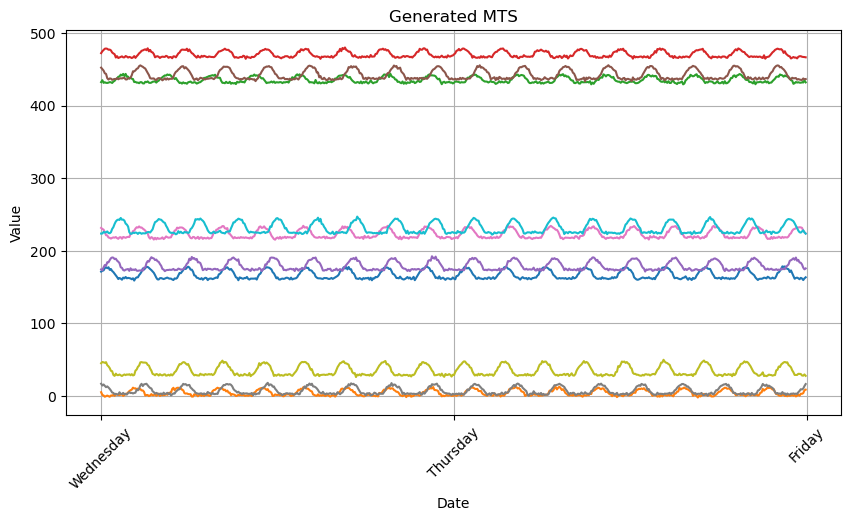

In [58]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="Seasonality",
                                                           occurance=1,
                                                           return_gen=True,
                                                           anomalies=False)

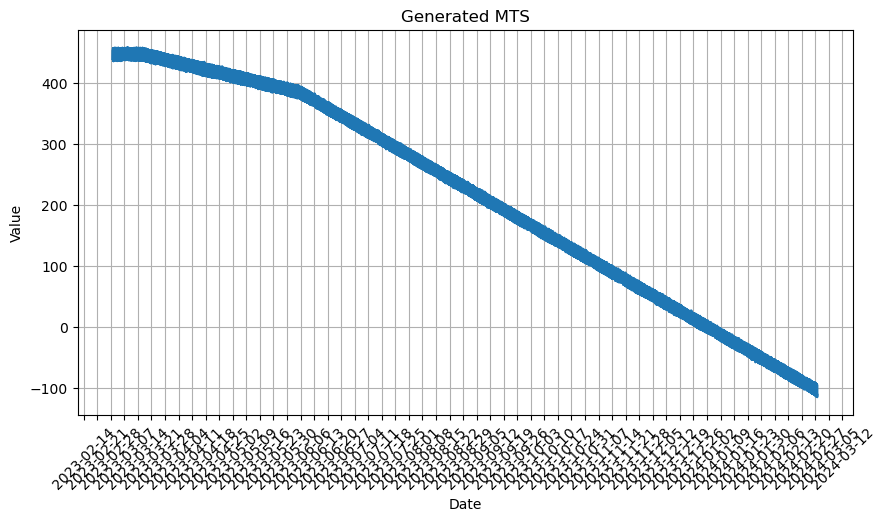

torch.Size([1, 10484])
torch.Size([18, 1, 576])


In [4]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=2,
                                                                            return_gen=True,
                                                                            anomalies=False)

In [5]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

NameError: name 'train_data_long' is not defined

In [59]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)
# indices = indices.mean(axis=-1).type(torch.int32)

labels = extract_parameters(args, e_params=e_params, effects=effects)
# labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

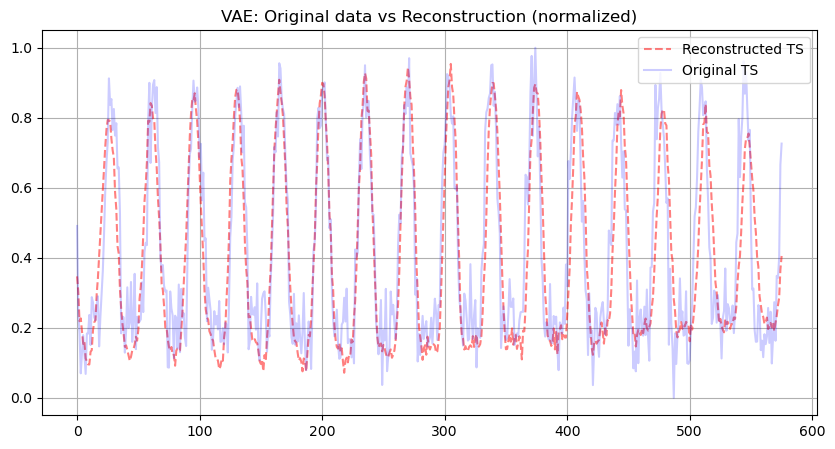

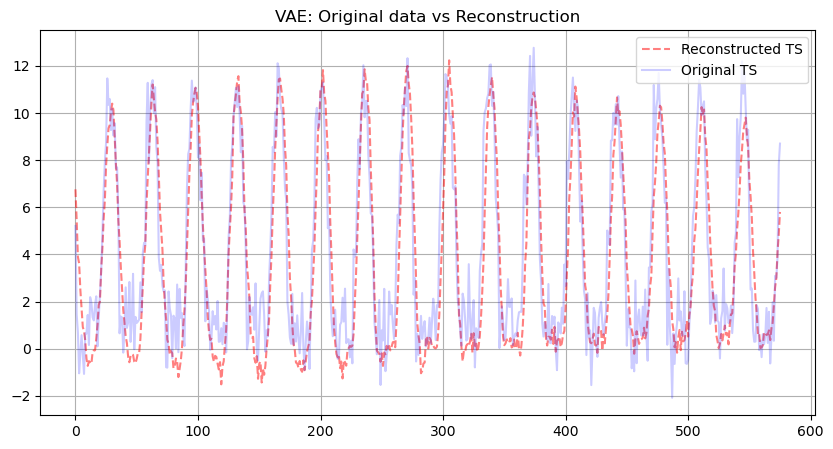

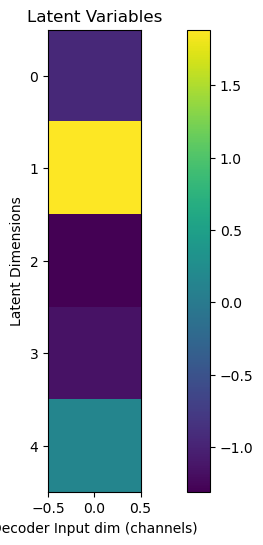

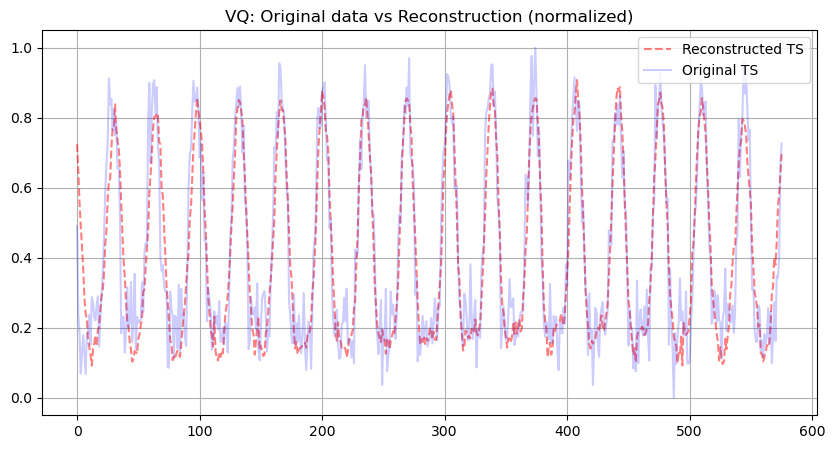

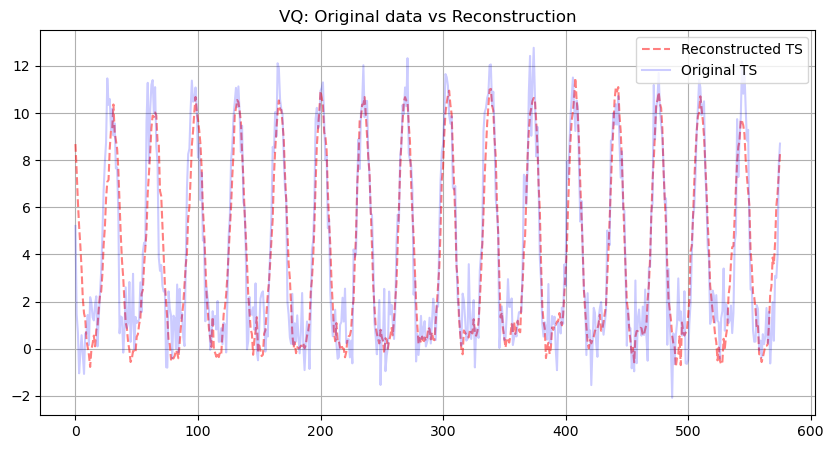

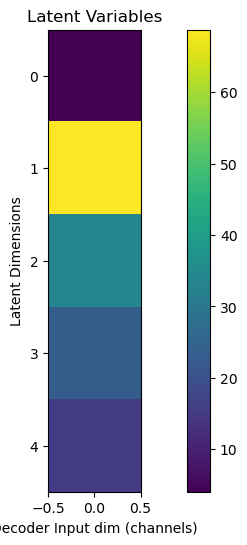

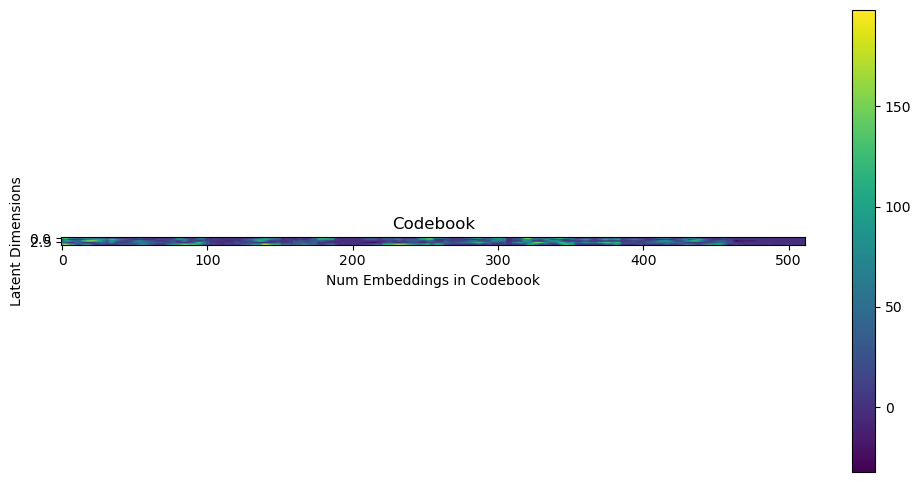

====> VAE: Sample 201 Average loss: 0.0058
====> VQ: Sample 201 Average loss: 0.0029
Train Epoch: 202 [0/16 (0%)]	Loss: 23.639587	 True Loss: 6051.734375
Train Epoch: 202 [0/16 (0%)]	Loss: 11.833084	 True Loss: 3029.269531
====> VAE: Sample 202 Average loss: 0.0059
====> VQ: Sample 202 Average loss: 0.0029
Train Epoch: 203 [0/16 (0%)]	Loss: 23.644997	 True Loss: 6053.119141
Train Epoch: 203 [0/16 (0%)]	Loss: 12.072925	 True Loss: 3090.668701
====> VAE: Sample 203 Average loss: 0.0058
====> VQ: Sample 203 Average loss: 0.0029
Train Epoch: 204 [0/16 (0%)]	Loss: 23.797174	 True Loss: 6092.076660
Train Epoch: 204 [0/16 (0%)]	Loss: 12.020442	 True Loss: 3077.233154
====> VAE: Sample 204 Average loss: 0.0059
====> VQ: Sample 204 Average loss: 0.0029
Train Epoch: 205 [0/16 (0%)]	Loss: 24.517410	 True Loss: 6276.457031
Train Epoch: 205 [0/16 (0%)]	Loss: 11.248392	 True Loss: 2879.588379
====> VAE: Sample 205 Average loss: 0.0059
====> VQ: Sample 205 Average loss: 0.0029
Train Epoch: 206 [0/16 

====> VAE: Sample 238 Average loss: 0.0058
====> VQ: Sample 238 Average loss: 0.0025
Train Epoch: 239 [0/16 (0%)]	Loss: 23.828114	 True Loss: 6099.997070
Train Epoch: 239 [0/16 (0%)]	Loss: 10.460046	 True Loss: 2677.771729
====> VAE: Sample 239 Average loss: 0.0058
====> VQ: Sample 239 Average loss: 0.0025
Train Epoch: 240 [0/16 (0%)]	Loss: 23.079926	 True Loss: 5908.460938
Train Epoch: 240 [0/16 (0%)]	Loss: 10.370423	 True Loss: 2654.828369
====> VAE: Sample 240 Average loss: 0.0058
====> VQ: Sample 240 Average loss: 0.0025
Train Epoch: 241 [0/16 (0%)]	Loss: 23.829948	 True Loss: 6100.466797
Train Epoch: 241 [0/16 (0%)]	Loss: 10.116371	 True Loss: 2589.791016
====> VAE: Sample 241 Average loss: 0.0058
====> VQ: Sample 241 Average loss: 0.0025
Train Epoch: 242 [0/16 (0%)]	Loss: 22.854544	 True Loss: 5850.763184


KeyboardInterrupt: 

In [61]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []
args.min_max=True

for epoch in range(1, 500):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args, plot_latent=False)
        show_results(vq, train_data, args, vq=True, plot_latent=False)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

In [149]:
from disentangelement import identifier
id_mlp_vae = identifier(args=args, n_layers=1, output_size=labels.shape[-1])
id_mlp_vq = identifier(args=args, n_layers=1, output_size=labels.shape[-1])

id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)

id_mlp_vae_opt = optim.Adam(id_mlp_vae.parameters(), lr = 0.01)
id_mlp_vq_opt = optim.Adam(id_mlp_vq.parameters(), lr = 0.01)

In [150]:
id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)
for epoch in range(1,1000):
    y_train_pred_mlp_vae = train_identifier_modified(vae, id_mlp_vae,train_data, id_mlp_vae_opt, args, epoch)
    y_train_pred_mlp_vq = train_identifier_modified(vq, id_mlp_vq,train_data, id_mlp_vq_opt, args, epoch)
id_mlp_vae = id_mlp_vae.to("cpu")
id_mlp_vq = id_mlp_vq.to("cpu")

Train Epoch: 1 [0/4000 (0%)]	Loss: 7.205839
====> Epoch: 1 Average loss: 7.3867
True Loss:  29546.665649414062
Train Epoch: 1 [0/4000 (0%)]	Loss: 7.207630
====> Epoch: 1 Average loss: 7.3894
True Loss:  29557.659301757812
Train Epoch: 2 [0/4000 (0%)]	Loss: 7.159343
====> Epoch: 2 Average loss: 7.3396
True Loss:  29358.207275390625
Train Epoch: 2 [0/4000 (0%)]	Loss: 7.161582
====> Epoch: 2 Average loss: 7.3423
True Loss:  29369.196044921875
Train Epoch: 3 [0/4000 (0%)]	Loss: 7.113584
====> Epoch: 3 Average loss: 7.2929
True Loss:  29171.585815429688
Train Epoch: 3 [0/4000 (0%)]	Loss: 7.116243
====> Epoch: 3 Average loss: 7.2959
True Loss:  29183.64599609375
Train Epoch: 4 [0/4000 (0%)]	Loss: 7.068150
====> Epoch: 4 Average loss: 7.2470
True Loss:  28987.910034179688
Train Epoch: 4 [0/4000 (0%)]	Loss: 7.071499
====> Epoch: 4 Average loss: 7.2502
True Loss:  29000.629272460938
Train Epoch: 5 [0/4000 (0%)]	Loss: 7.023747
====> Epoch: 5 Average loss: 7.2013
True Loss:  28805.37548828125
Tra

====> Epoch: 37 Average loss: 5.9199
True Loss:  23679.553833007812
Train Epoch: 38 [0/4000 (0%)]	Loss: 5.730330
====> Epoch: 38 Average loss: 5.8798
True Loss:  23519.059204101562
Train Epoch: 38 [0/4000 (0%)]	Loss: 5.734098
====> Epoch: 38 Average loss: 5.8838
True Loss:  23535.185791015625
Train Epoch: 39 [0/4000 (0%)]	Loss: 5.694287
====> Epoch: 39 Average loss: 5.8440
True Loss:  23376.1376953125
Train Epoch: 39 [0/4000 (0%)]	Loss: 5.699032
====> Epoch: 39 Average loss: 5.8480
True Loss:  23391.854125976562
Train Epoch: 40 [0/4000 (0%)]	Loss: 5.659641
====> Epoch: 40 Average loss: 5.8083
True Loss:  23233.186767578125
Train Epoch: 40 [0/4000 (0%)]	Loss: 5.664179
====> Epoch: 40 Average loss: 5.8124
True Loss:  23249.456298828125
Train Epoch: 41 [0/4000 (0%)]	Loss: 5.624724
====> Epoch: 41 Average loss: 5.7730
True Loss:  23092.09228515625
Train Epoch: 41 [0/4000 (0%)]	Loss: 5.629570
====> Epoch: 41 Average loss: 5.7770
True Loss:  23107.970947265625
Train Epoch: 42 [0/4000 (0%)]	L

====> Epoch: 74 Average loss: 4.7147
True Loss:  18858.632690429688
Train Epoch: 74 [0/4000 (0%)]	Loss: 4.594871
====> Epoch: 74 Average loss: 4.7185
True Loss:  18874.045654296875
Train Epoch: 75 [0/4000 (0%)]	Loss: 4.561917
====> Epoch: 75 Average loss: 4.6855
True Loss:  18742.1572265625
Train Epoch: 75 [0/4000 (0%)]	Loss: 4.566402
====> Epoch: 75 Average loss: 4.6894
True Loss:  18757.531616210938
Train Epoch: 76 [0/4000 (0%)]	Loss: 4.534066
====> Epoch: 76 Average loss: 4.6566
True Loss:  18626.326416015625
Train Epoch: 76 [0/4000 (0%)]	Loss: 4.538096
====> Epoch: 76 Average loss: 4.6604
True Loss:  18641.596435546875
Train Epoch: 77 [0/4000 (0%)]	Loss: 4.506397
====> Epoch: 77 Average loss: 4.6278
True Loss:  18511.105712890625
Train Epoch: 77 [0/4000 (0%)]	Loss: 4.509918
====> Epoch: 77 Average loss: 4.6316
True Loss:  18526.25341796875
Train Epoch: 78 [0/4000 (0%)]	Loss: 4.478041
====> Epoch: 78 Average loss: 4.5990
True Loss:  18395.920288085938
Train Epoch: 78 [0/4000 (0%)]	L

====> Epoch: 110 Average loss: 3.7573
True Loss:  15029.046813964844
Train Epoch: 111 [0/4000 (0%)]	Loss: 3.628033
====> Epoch: 111 Average loss: 3.7292
True Loss:  14916.905517578125
Train Epoch: 111 [0/4000 (0%)]	Loss: 3.632514
====> Epoch: 111 Average loss: 3.7329
True Loss:  14931.554443359375
Train Epoch: 112 [0/4000 (0%)]	Loss: 3.604171
====> Epoch: 112 Average loss: 3.7049
True Loss:  14819.721923828125
Train Epoch: 112 [0/4000 (0%)]	Loss: 3.608809
====> Epoch: 112 Average loss: 3.7086
True Loss:  14834.541320800781
Train Epoch: 113 [0/4000 (0%)]	Loss: 3.581037
====> Epoch: 113 Average loss: 3.6807
True Loss:  14722.918273925781
Train Epoch: 113 [0/4000 (0%)]	Loss: 3.585304
====> Epoch: 113 Average loss: 3.6845
True Loss:  14737.974914550781
Train Epoch: 114 [0/4000 (0%)]	Loss: 3.558365
====> Epoch: 114 Average loss: 3.6570
True Loss:  14627.942565917969
Train Epoch: 114 [0/4000 (0%)]	Loss: 3.561821
====> Epoch: 114 Average loss: 3.6605
True Loss:  14641.852355957031
Train Epoch

====> Epoch: 146 Average loss: 2.9471
True Loss:  11788.405151367188
Train Epoch: 147 [0/4000 (0%)]	Loss: 2.841911
====> Epoch: 147 Average loss: 2.9225
True Loss:  11689.950317382812
Train Epoch: 147 [0/4000 (0%)]	Loss: 2.845907
====> Epoch: 147 Average loss: 2.9264
True Loss:  11705.726257324219
Train Epoch: 148 [0/4000 (0%)]	Loss: 2.821754
====> Epoch: 148 Average loss: 2.9023
True Loss:  11609.076538085938
Train Epoch: 148 [0/4000 (0%)]	Loss: 2.825912
====> Epoch: 148 Average loss: 2.9059
True Loss:  11623.646057128906
Train Epoch: 149 [0/4000 (0%)]	Loss: 2.801383
====> Epoch: 149 Average loss: 2.8817
True Loss:  11526.797607421875
Train Epoch: 149 [0/4000 (0%)]	Loss: 2.806062
====> Epoch: 149 Average loss: 2.8855
True Loss:  11541.889526367188
Train Epoch: 150 [0/4000 (0%)]	Loss: 2.781246
====> Epoch: 150 Average loss: 2.8613
True Loss:  11445.357177734375
Train Epoch: 150 [0/4000 (0%)]	Loss: 2.786099
====> Epoch: 150 Average loss: 2.8651
True Loss:  11460.321411132812
Train Epoch

====> Epoch: 182 Average loss: 2.2623
True Loss:  9049.017028808594
Train Epoch: 183 [0/4000 (0%)]	Loss: 2.177336
====> Epoch: 183 Average loss: 2.2411
True Loss:  8964.411926269531
Train Epoch: 183 [0/4000 (0%)]	Loss: 2.181754
====> Epoch: 183 Average loss: 2.2449
True Loss:  8979.712463378906
Train Epoch: 184 [0/4000 (0%)]	Loss: 2.160175
====> Epoch: 184 Average loss: 2.2240
True Loss:  8895.870727539062
Train Epoch: 184 [0/4000 (0%)]	Loss: 2.164805
====> Epoch: 184 Average loss: 2.2276
True Loss:  8910.470520019531
Train Epoch: 185 [0/4000 (0%)]	Loss: 2.143224
====> Epoch: 185 Average loss: 2.2068
True Loss:  8827.059509277344
Train Epoch: 185 [0/4000 (0%)]	Loss: 2.148043
====> Epoch: 185 Average loss: 2.2104
True Loss:  8841.704040527344
Train Epoch: 186 [0/4000 (0%)]	Loss: 2.127081
====> Epoch: 186 Average loss: 2.1896
True Loss:  8758.388000488281
Train Epoch: 186 [0/4000 (0%)]	Loss: 2.131429
====> Epoch: 186 Average loss: 2.1933
True Loss:  8773.320190429688
Train Epoch: 187 [0/

====> Epoch: 218 Average loss: 1.6903
True Loss:  6761.052520751953
Train Epoch: 219 [0/4000 (0%)]	Loss: 1.622850
====> Epoch: 219 Average loss: 1.6721
True Loss:  6688.34521484375
Train Epoch: 219 [0/4000 (0%)]	Loss: 1.627391
====> Epoch: 219 Average loss: 1.6759
True Loss:  6703.581848144531
Train Epoch: 220 [0/4000 (0%)]	Loss: 1.609532
====> Epoch: 220 Average loss: 1.6579
True Loss:  6631.71875
Train Epoch: 220 [0/4000 (0%)]	Loss: 1.613458
====> Epoch: 220 Average loss: 1.6616
True Loss:  6646.329437255859
Train Epoch: 221 [0/4000 (0%)]	Loss: 1.594938
====> Epoch: 221 Average loss: 1.6436
True Loss:  6574.462188720703
Train Epoch: 221 [0/4000 (0%)]	Loss: 1.599615
====> Epoch: 221 Average loss: 1.6474
True Loss:  6589.5001220703125
Train Epoch: 222 [0/4000 (0%)]	Loss: 1.581473
====> Epoch: 222 Average loss: 1.6292
True Loss:  6516.943298339844
Train Epoch: 222 [0/4000 (0%)]	Loss: 1.585829
====> Epoch: 222 Average loss: 1.6332
True Loss:  6532.932464599609
Train Epoch: 223 [0/4000 (0

====> Epoch: 254 Average loss: 1.2217
True Loss:  4886.905792236328
Train Epoch: 255 [0/4000 (0%)]	Loss: 1.169317
====> Epoch: 255 Average loss: 1.2065
True Loss:  4825.938781738281
Train Epoch: 255 [0/4000 (0%)]	Loss: 1.173890
====> Epoch: 255 Average loss: 1.2101
True Loss:  4840.385009765625
Train Epoch: 256 [0/4000 (0%)]	Loss: 1.158520
====> Epoch: 256 Average loss: 1.1948
True Loss:  4779.342864990234
Train Epoch: 256 [0/4000 (0%)]	Loss: 1.162709
====> Epoch: 256 Average loss: 1.1986
True Loss:  4794.257568359375
Train Epoch: 257 [0/4000 (0%)]	Loss: 1.146795
====> Epoch: 257 Average loss: 1.1834
True Loss:  4733.440826416016
Train Epoch: 257 [0/4000 (0%)]	Loss: 1.151549
====> Epoch: 257 Average loss: 1.1871
True Loss:  4748.383850097656
Train Epoch: 258 [0/4000 (0%)]	Loss: 1.136243
====> Epoch: 258 Average loss: 1.1720
True Loss:  4688.1856689453125
Train Epoch: 258 [0/4000 (0%)]	Loss: 1.140463
====> Epoch: 258 Average loss: 1.1757
True Loss:  4702.8035888671875
Train Epoch: 259 [

====> Epoch: 290 Average loss: 0.8482
True Loss:  3392.8653869628906
Train Epoch: 291 [0/4000 (0%)]	Loss: 0.809193
====> Epoch: 291 Average loss: 0.8354
True Loss:  3341.6659393310547
Train Epoch: 291 [0/4000 (0%)]	Loss: 0.812956
====> Epoch: 291 Average loss: 0.8391
True Loss:  3356.317855834961
Train Epoch: 292 [0/4000 (0%)]	Loss: 0.799920
====> Epoch: 292 Average loss: 0.8264
True Loss:  3305.6109161376953
Train Epoch: 292 [0/4000 (0%)]	Loss: 0.804191
====> Epoch: 292 Average loss: 0.8300
True Loss:  3320.187713623047
Train Epoch: 293 [0/4000 (0%)]	Loss: 0.791229
====> Epoch: 293 Average loss: 0.8174
True Loss:  3269.7742919921875
Train Epoch: 293 [0/4000 (0%)]	Loss: 0.795515
====> Epoch: 293 Average loss: 0.8211
True Loss:  3284.3367767333984
Train Epoch: 294 [0/4000 (0%)]	Loss: 0.782800
====> Epoch: 294 Average loss: 0.8087
True Loss:  3234.7343139648438
Train Epoch: 294 [0/4000 (0%)]	Loss: 0.786858
====> Epoch: 294 Average loss: 0.8122
True Loss:  3248.751205444336
Train Epoch: 2

====> Epoch: 326 Average loss: 0.5611
True Loss:  2244.3262786865234
Train Epoch: 327 [0/4000 (0%)]	Loss: 0.531548
====> Epoch: 327 Average loss: 0.5505
True Loss:  2201.8428955078125
Train Epoch: 327 [0/4000 (0%)]	Loss: 0.536227
====> Epoch: 327 Average loss: 0.5543
True Loss:  2217.050567626953
Train Epoch: 328 [0/4000 (0%)]	Loss: 0.525345
====> Epoch: 328 Average loss: 0.5437
True Loss:  2174.800048828125
Train Epoch: 328 [0/4000 (0%)]	Loss: 0.529644
====> Epoch: 328 Average loss: 0.5475
True Loss:  2189.9969177246094
Train Epoch: 329 [0/4000 (0%)]	Loss: 0.519332
====> Epoch: 329 Average loss: 0.5371
True Loss:  2148.306427001953
Train Epoch: 329 [0/4000 (0%)]	Loss: 0.523145
====> Epoch: 329 Average loss: 0.5408
True Loss:  2163.2137145996094
Train Epoch: 330 [0/4000 (0%)]	Loss: 0.511909
====> Epoch: 330 Average loss: 0.5304
True Loss:  2121.661819458008
Train Epoch: 330 [0/4000 (0%)]	Loss: 0.516660
====> Epoch: 330 Average loss: 0.5341
True Loss:  2136.599411010742
Train Epoch: 331

====> Epoch: 362 Average loss: 0.3512
True Loss:  1404.8975219726562
Train Epoch: 363 [0/4000 (0%)]	Loss: 0.329715
====> Epoch: 363 Average loss: 0.3427
True Loss:  1370.623176574707
Train Epoch: 363 [0/4000 (0%)]	Loss: 0.334471
====> Epoch: 363 Average loss: 0.3464
True Loss:  1385.550651550293
Train Epoch: 364 [0/4000 (0%)]	Loss: 0.325417
====> Epoch: 364 Average loss: 0.3380
True Loss:  1352.0900421142578
Train Epoch: 364 [0/4000 (0%)]	Loss: 0.329872
====> Epoch: 364 Average loss: 0.3416
True Loss:  1366.4244003295898
Train Epoch: 365 [0/4000 (0%)]	Loss: 0.321198
====> Epoch: 365 Average loss: 0.3330
True Loss:  1332.122444152832
Train Epoch: 365 [0/4000 (0%)]	Loss: 0.325231
====> Epoch: 365 Average loss: 0.3369
True Loss:  1347.467170715332
Train Epoch: 366 [0/4000 (0%)]	Loss: 0.316510
====> Epoch: 366 Average loss: 0.3285
True Loss:  1313.9949645996094
Train Epoch: 366 [0/4000 (0%)]	Loss: 0.320782
====> Epoch: 366 Average loss: 0.3322
True Loss:  1328.8251113891602
Train Epoch: 36

====> Epoch: 398 Average loss: 0.2081
True Loss:  832.2305068969727
Train Epoch: 399 [0/4000 (0%)]	Loss: 0.192715
====> Epoch: 399 Average loss: 0.2012
True Loss:  804.7228965759277
Train Epoch: 399 [0/4000 (0%)]	Loss: 0.197595
====> Epoch: 399 Average loss: 0.2049
True Loss:  819.7056350708008
Train Epoch: 400 [0/4000 (0%)]	Loss: 0.189669
====> Epoch: 400 Average loss: 0.1979
True Loss:  791.6167831420898
Train Epoch: 400 [0/4000 (0%)]	Loss: 0.194592
====> Epoch: 400 Average loss: 0.2018
True Loss:  807.2919883728027
Train Epoch: 401 [0/4000 (0%)]	Loss: 0.186257
====> Epoch: 401 Average loss: 0.1950
True Loss:  780.0672149658203
Train Epoch: 401 [0/4000 (0%)]	Loss: 0.191614
====> Epoch: 401 Average loss: 0.1988
True Loss:  795.0548896789551
Train Epoch: 402 [0/4000 (0%)]	Loss: 0.184206
====> Epoch: 402 Average loss: 0.1920
True Loss:  768.0292167663574
Train Epoch: 402 [0/4000 (0%)]	Loss: 0.188706
====> Epoch: 402 Average loss: 0.1957
True Loss:  782.9664039611816
Train Epoch: 403 [0/

====> Epoch: 434 Average loss: 0.1195
True Loss:  478.1329288482666
Train Epoch: 435 [0/4000 (0%)]	Loss: 0.109386
====> Epoch: 435 Average loss: 0.1139
True Loss:  455.76390647888184
Train Epoch: 435 [0/4000 (0%)]	Loss: 0.113582
====> Epoch: 435 Average loss: 0.1177
True Loss:  470.9002208709717
Train Epoch: 436 [0/4000 (0%)]	Loss: 0.106842
====> Epoch: 436 Average loss: 0.1121
True Loss:  448.4567699432373
Train Epoch: 436 [0/4000 (0%)]	Loss: 0.111818
====> Epoch: 436 Average loss: 0.1159
True Loss:  463.70376205444336
Train Epoch: 437 [0/4000 (0%)]	Loss: 0.106088
====> Epoch: 437 Average loss: 0.1104
True Loss:  441.7892818450928
Train Epoch: 437 [0/4000 (0%)]	Loss: 0.110165
====> Epoch: 437 Average loss: 0.1142
True Loss:  456.749792098999
Train Epoch: 438 [0/4000 (0%)]	Loss: 0.103508
====> Epoch: 438 Average loss: 0.1087
True Loss:  434.97047233581543
Train Epoch: 438 [0/4000 (0%)]	Loss: 0.108579
====> Epoch: 438 Average loss: 0.1125
True Loss:  449.9775562286377
Train Epoch: 439 [

====> Epoch: 470 Average loss: 0.0720
True Loss:  287.84607887268066
Train Epoch: 471 [0/4000 (0%)]	Loss: 0.064341
====> Epoch: 471 Average loss: 0.0671
True Loss:  268.33899211883545
Train Epoch: 471 [0/4000 (0%)]	Loss: 0.068994
====> Epoch: 471 Average loss: 0.0711
True Loss:  284.32347106933594
Train Epoch: 472 [0/4000 (0%)]	Loss: 0.063797
====> Epoch: 472 Average loss: 0.0665
True Loss:  265.8551445007324
Train Epoch: 472 [0/4000 (0%)]	Loss: 0.068277
====> Epoch: 472 Average loss: 0.0703
True Loss:  281.0220012664795
Train Epoch: 473 [0/4000 (0%)]	Loss: 0.062053
====> Epoch: 473 Average loss: 0.0656
True Loss:  262.2024040222168
Train Epoch: 473 [0/4000 (0%)]	Loss: 0.067457
====> Epoch: 473 Average loss: 0.0694
True Loss:  277.65894317626953
Train Epoch: 474 [0/4000 (0%)]	Loss: 0.062322
====> Epoch: 474 Average loss: 0.0648
True Loss:  259.09754753112793
Train Epoch: 474 [0/4000 (0%)]	Loss: 0.066620
====> Epoch: 474 Average loss: 0.0686
True Loss:  274.34009075164795
Train Epoch: 4

====> Epoch: 506 Average loss: 0.0511
True Loss:  204.58520698547363
Train Epoch: 507 [0/4000 (0%)]	Loss: 0.046050
====> Epoch: 507 Average loss: 0.0470
True Loss:  188.09277725219727
Train Epoch: 507 [0/4000 (0%)]	Loss: 0.050013
====> Epoch: 507 Average loss: 0.0508
True Loss:  203.2201633453369
Train Epoch: 508 [0/4000 (0%)]	Loss: 0.044988
====> Epoch: 508 Average loss: 0.0469
True Loss:  187.71171760559082
Train Epoch: 508 [0/4000 (0%)]	Loss: 0.049743
====> Epoch: 508 Average loss: 0.0505
True Loss:  202.0096025466919
Train Epoch: 509 [0/4000 (0%)]	Loss: 0.045374
====> Epoch: 509 Average loss: 0.0465
True Loss:  185.94995594024658
Train Epoch: 509 [0/4000 (0%)]	Loss: 0.049462
====> Epoch: 509 Average loss: 0.0502
True Loss:  200.81055164337158
Train Epoch: 510 [0/4000 (0%)]	Loss: 0.045218
====> Epoch: 510 Average loss: 0.0460
True Loss:  184.12578296661377
Train Epoch: 510 [0/4000 (0%)]	Loss: 0.049154
====> Epoch: 510 Average loss: 0.0499
True Loss:  199.59728527069092
Train Epoch: 

====> Epoch: 542 Average loss: 0.0443
True Loss:  177.33556270599365
Train Epoch: 543 [0/4000 (0%)]	Loss: 0.040366
====> Epoch: 543 Average loss: 0.0405
True Loss:  161.9099235534668
Train Epoch: 543 [0/4000 (0%)]	Loss: 0.044202
====> Epoch: 543 Average loss: 0.0443
True Loss:  177.01780891418457
Train Epoch: 544 [0/4000 (0%)]	Loss: 0.039428
====> Epoch: 544 Average loss: 0.0405
True Loss:  161.8696632385254
Train Epoch: 544 [0/4000 (0%)]	Loss: 0.044229
====> Epoch: 544 Average loss: 0.0442
True Loss:  176.78418445587158
Train Epoch: 545 [0/4000 (0%)]	Loss: 0.039764
====> Epoch: 545 Average loss: 0.0404
True Loss:  161.48795890808105
Train Epoch: 545 [0/4000 (0%)]	Loss: 0.044106
====> Epoch: 545 Average loss: 0.0441
True Loss:  176.47987461090088
Train Epoch: 546 [0/4000 (0%)]	Loss: 0.039849
====> Epoch: 546 Average loss: 0.0402
True Loss:  160.89258575439453
Train Epoch: 546 [0/4000 (0%)]	Loss: 0.043955
====> Epoch: 546 Average loss: 0.0440
True Loss:  176.05533695220947
Train Epoch: 

====> Epoch: 578 Average loss: 0.0429
True Loss:  171.61222171783447
Train Epoch: 579 [0/4000 (0%)]	Loss: 0.039650
====> Epoch: 579 Average loss: 0.0393
True Loss:  157.00412845611572
Train Epoch: 579 [0/4000 (0%)]	Loss: 0.043262
====> Epoch: 579 Average loss: 0.0429
True Loss:  171.58318424224854
Train Epoch: 580 [0/4000 (0%)]	Loss: 0.038878
====> Epoch: 580 Average loss: 0.0393
True Loss:  157.30243015289307
Train Epoch: 580 [0/4000 (0%)]	Loss: 0.043195
====> Epoch: 580 Average loss: 0.0429
True Loss:  171.46166038513184
Train Epoch: 581 [0/4000 (0%)]	Loss: 0.039413
====> Epoch: 581 Average loss: 0.0392
True Loss:  156.8327398300171
Train Epoch: 581 [0/4000 (0%)]	Loss: 0.043135
====> Epoch: 581 Average loss: 0.0428
True Loss:  171.3847541809082
Train Epoch: 582 [0/4000 (0%)]	Loss: 0.039376
====> Epoch: 582 Average loss: 0.0391
True Loss:  156.53208446502686
Train Epoch: 582 [0/4000 (0%)]	Loss: 0.043189
====> Epoch: 582 Average loss: 0.0428
True Loss:  171.3740119934082
Train Epoch: 5

====> Epoch: 614 Average loss: 0.0427
True Loss:  170.88990592956543
Train Epoch: 615 [0/4000 (0%)]	Loss: 0.038550
====> Epoch: 615 Average loss: 0.0389
True Loss:  155.63787651062012
Train Epoch: 615 [0/4000 (0%)]	Loss: 0.043118
====> Epoch: 615 Average loss: 0.0427
True Loss:  170.76119136810303
Train Epoch: 616 [0/4000 (0%)]	Loss: 0.039594
====> Epoch: 616 Average loss: 0.0391
True Loss:  156.26314067840576
Train Epoch: 616 [0/4000 (0%)]	Loss: 0.043205
====> Epoch: 616 Average loss: 0.0427
True Loss:  170.78579330444336
Train Epoch: 617 [0/4000 (0%)]	Loss: 0.038784
====> Epoch: 617 Average loss: 0.0389
True Loss:  155.50270652770996
Train Epoch: 617 [0/4000 (0%)]	Loss: 0.043241
====> Epoch: 617 Average loss: 0.0427
True Loss:  170.9256477355957
Train Epoch: 618 [0/4000 (0%)]	Loss: 0.038761
====> Epoch: 618 Average loss: 0.0387
True Loss:  154.8297634124756
Train Epoch: 618 [0/4000 (0%)]	Loss: 0.043200
====> Epoch: 618 Average loss: 0.0427
True Loss:  170.8185453414917
Train Epoch: 6

====> Epoch: 650 Average loss: 0.0427
True Loss:  170.80991172790527
Train Epoch: 651 [0/4000 (0%)]	Loss: 0.039025
====> Epoch: 651 Average loss: 0.0391
True Loss:  156.52963638305664
Train Epoch: 651 [0/4000 (0%)]	Loss: 0.043158
====> Epoch: 651 Average loss: 0.0427
True Loss:  170.74364757537842
Train Epoch: 652 [0/4000 (0%)]	Loss: 0.038500
====> Epoch: 652 Average loss: 0.0390
True Loss:  155.87742042541504
Train Epoch: 652 [0/4000 (0%)]	Loss: 0.043219
====> Epoch: 652 Average loss: 0.0427
True Loss:  170.74165439605713
Train Epoch: 653 [0/4000 (0%)]	Loss: 0.038776
====> Epoch: 653 Average loss: 0.0390
True Loss:  155.92597103118896
Train Epoch: 653 [0/4000 (0%)]	Loss: 0.043256
====> Epoch: 653 Average loss: 0.0427
True Loss:  170.86187076568604
Train Epoch: 654 [0/4000 (0%)]	Loss: 0.038946
====> Epoch: 654 Average loss: 0.0390
True Loss:  156.13860702514648
Train Epoch: 654 [0/4000 (0%)]	Loss: 0.043192
====> Epoch: 654 Average loss: 0.0427
True Loss:  170.77569198608398
Train Epoch

====> Epoch: 686 Average loss: 0.0427
True Loss:  170.77383613586426
Train Epoch: 687 [0/4000 (0%)]	Loss: 0.038637
====> Epoch: 687 Average loss: 0.0390
True Loss:  155.800518989563
Train Epoch: 687 [0/4000 (0%)]	Loss: 0.043200
====> Epoch: 687 Average loss: 0.0427
True Loss:  170.76356601715088
Train Epoch: 688 [0/4000 (0%)]	Loss: 0.038896
====> Epoch: 688 Average loss: 0.0389
True Loss:  155.7245101928711
Train Epoch: 688 [0/4000 (0%)]	Loss: 0.043223
====> Epoch: 688 Average loss: 0.0427
True Loss:  170.81529808044434
Train Epoch: 689 [0/4000 (0%)]	Loss: 0.038588
====> Epoch: 689 Average loss: 0.0390
True Loss:  156.04991149902344
Train Epoch: 689 [0/4000 (0%)]	Loss: 0.043208
====> Epoch: 689 Average loss: 0.0427
True Loss:  170.80482959747314
Train Epoch: 690 [0/4000 (0%)]	Loss: 0.038821
====> Epoch: 690 Average loss: 0.0387
True Loss:  154.8790864944458
Train Epoch: 690 [0/4000 (0%)]	Loss: 0.043214
====> Epoch: 690 Average loss: 0.0427
True Loss:  170.78602409362793
Train Epoch: 69

====> Epoch: 722 Average loss: 0.0427
True Loss:  170.7729845046997
Train Epoch: 723 [0/4000 (0%)]	Loss: 0.038619
====> Epoch: 723 Average loss: 0.0389
True Loss:  155.42373371124268
Train Epoch: 723 [0/4000 (0%)]	Loss: 0.043220
====> Epoch: 723 Average loss: 0.0427
True Loss:  170.8010549545288
Train Epoch: 724 [0/4000 (0%)]	Loss: 0.039315
====> Epoch: 724 Average loss: 0.0391
True Loss:  156.40173721313477
Train Epoch: 724 [0/4000 (0%)]	Loss: 0.043223
====> Epoch: 724 Average loss: 0.0427
True Loss:  170.77446842193604
Train Epoch: 725 [0/4000 (0%)]	Loss: 0.038330
====> Epoch: 725 Average loss: 0.0389
True Loss:  155.5485496520996
Train Epoch: 725 [0/4000 (0%)]	Loss: 0.043217
====> Epoch: 725 Average loss: 0.0427
True Loss:  170.74469757080078
Train Epoch: 726 [0/4000 (0%)]	Loss: 0.038523
====> Epoch: 726 Average loss: 0.0390
True Loss:  156.06667804718018
Train Epoch: 726 [0/4000 (0%)]	Loss: 0.043231
====> Epoch: 726 Average loss: 0.0427
True Loss:  170.81764316558838
Train Epoch: 7

====> Epoch: 758 Average loss: 0.0427
True Loss:  170.83407878875732
Train Epoch: 759 [0/4000 (0%)]	Loss: 0.037858
====> Epoch: 759 Average loss: 0.0388
True Loss:  155.16597747802734
Train Epoch: 759 [0/4000 (0%)]	Loss: 0.043214
====> Epoch: 759 Average loss: 0.0427
True Loss:  170.78353023529053
Train Epoch: 760 [0/4000 (0%)]	Loss: 0.038387
====> Epoch: 760 Average loss: 0.0388
True Loss:  155.33964252471924
Train Epoch: 760 [0/4000 (0%)]	Loss: 0.043238
====> Epoch: 760 Average loss: 0.0427
True Loss:  170.75317573547363
Train Epoch: 761 [0/4000 (0%)]	Loss: 0.039122
====> Epoch: 761 Average loss: 0.0389
True Loss:  155.43722438812256
Train Epoch: 761 [0/4000 (0%)]	Loss: 0.043243
====> Epoch: 761 Average loss: 0.0427
True Loss:  170.82038593292236
Train Epoch: 762 [0/4000 (0%)]	Loss: 0.038086
====> Epoch: 762 Average loss: 0.0389
True Loss:  155.78268432617188
Train Epoch: 762 [0/4000 (0%)]	Loss: 0.043241
====> Epoch: 762 Average loss: 0.0427
True Loss:  170.76824378967285
Train Epoch

====> Epoch: 794 Average loss: 0.0427
True Loss:  170.7721767425537
Train Epoch: 795 [0/4000 (0%)]	Loss: 0.038453
====> Epoch: 795 Average loss: 0.0388
True Loss:  155.00652313232422
Train Epoch: 795 [0/4000 (0%)]	Loss: 0.043203
====> Epoch: 795 Average loss: 0.0427
True Loss:  170.78413105010986
Train Epoch: 796 [0/4000 (0%)]	Loss: 0.038696
====> Epoch: 796 Average loss: 0.0388
True Loss:  155.02276802062988
Train Epoch: 796 [0/4000 (0%)]	Loss: 0.043215
====> Epoch: 796 Average loss: 0.0427
True Loss:  170.78420543670654
Train Epoch: 797 [0/4000 (0%)]	Loss: 0.038650
====> Epoch: 797 Average loss: 0.0390
True Loss:  156.11916828155518
Train Epoch: 797 [0/4000 (0%)]	Loss: 0.043210
====> Epoch: 797 Average loss: 0.0427
True Loss:  170.81015872955322
Train Epoch: 798 [0/4000 (0%)]	Loss: 0.038895
====> Epoch: 798 Average loss: 0.0391
True Loss:  156.30134201049805
Train Epoch: 798 [0/4000 (0%)]	Loss: 0.043199
====> Epoch: 798 Average loss: 0.0427
True Loss:  170.7227954864502
Train Epoch: 

====> Epoch: 830 Average loss: 0.0427
True Loss:  170.7842893600464
Train Epoch: 831 [0/4000 (0%)]	Loss: 0.038392
====> Epoch: 831 Average loss: 0.0389
True Loss:  155.40919017791748
Train Epoch: 831 [0/4000 (0%)]	Loss: 0.043228
====> Epoch: 831 Average loss: 0.0427
True Loss:  170.83852767944336
Train Epoch: 832 [0/4000 (0%)]	Loss: 0.039029
====> Epoch: 832 Average loss: 0.0388
True Loss:  155.2942705154419
Train Epoch: 832 [0/4000 (0%)]	Loss: 0.043248
====> Epoch: 832 Average loss: 0.0427
True Loss:  170.7946310043335
Train Epoch: 833 [0/4000 (0%)]	Loss: 0.038774
====> Epoch: 833 Average loss: 0.0390
True Loss:  155.81773281097412
Train Epoch: 833 [0/4000 (0%)]	Loss: 0.043195
====> Epoch: 833 Average loss: 0.0427
True Loss:  170.75408363342285
Train Epoch: 834 [0/4000 (0%)]	Loss: 0.038955
====> Epoch: 834 Average loss: 0.0389
True Loss:  155.7590208053589
Train Epoch: 834 [0/4000 (0%)]	Loss: 0.043189
====> Epoch: 834 Average loss: 0.0427
True Loss:  170.75084781646729
Train Epoch: 83

====> Epoch: 866 Average loss: 0.0427
True Loss:  170.75637340545654
Train Epoch: 867 [0/4000 (0%)]	Loss: 0.038921
====> Epoch: 867 Average loss: 0.0390
True Loss:  155.94021129608154
Train Epoch: 867 [0/4000 (0%)]	Loss: 0.043217
====> Epoch: 867 Average loss: 0.0427
True Loss:  170.80564975738525
Train Epoch: 868 [0/4000 (0%)]	Loss: 0.038950
====> Epoch: 868 Average loss: 0.0392
True Loss:  156.93095779418945
Train Epoch: 868 [0/4000 (0%)]	Loss: 0.043204
====> Epoch: 868 Average loss: 0.0427
True Loss:  170.78011417388916
Train Epoch: 869 [0/4000 (0%)]	Loss: 0.038284
====> Epoch: 869 Average loss: 0.0390
True Loss:  156.1745262145996
Train Epoch: 869 [0/4000 (0%)]	Loss: 0.043207
====> Epoch: 869 Average loss: 0.0427
True Loss:  170.7924346923828
Train Epoch: 870 [0/4000 (0%)]	Loss: 0.038486
====> Epoch: 870 Average loss: 0.0389
True Loss:  155.43949508666992
Train Epoch: 870 [0/4000 (0%)]	Loss: 0.043196
====> Epoch: 870 Average loss: 0.0427
True Loss:  170.79359245300293
Train Epoch: 

====> Epoch: 902 Average loss: 0.0427
True Loss:  170.75968647003174
Train Epoch: 903 [0/4000 (0%)]	Loss: 0.038683
====> Epoch: 903 Average loss: 0.0391
True Loss:  156.4479055404663
Train Epoch: 903 [0/4000 (0%)]	Loss: 0.043221
====> Epoch: 903 Average loss: 0.0427
True Loss:  170.77159214019775
Train Epoch: 904 [0/4000 (0%)]	Loss: 0.038728
====> Epoch: 904 Average loss: 0.0389
True Loss:  155.650484085083
Train Epoch: 904 [0/4000 (0%)]	Loss: 0.043208
====> Epoch: 904 Average loss: 0.0427
True Loss:  170.72395610809326
Train Epoch: 905 [0/4000 (0%)]	Loss: 0.038940
====> Epoch: 905 Average loss: 0.0387
True Loss:  154.97685050964355
Train Epoch: 905 [0/4000 (0%)]	Loss: 0.043229
====> Epoch: 905 Average loss: 0.0427
True Loss:  170.7746696472168
Train Epoch: 906 [0/4000 (0%)]	Loss: 0.038317
====> Epoch: 906 Average loss: 0.0389
True Loss:  155.4451026916504
Train Epoch: 906 [0/4000 (0%)]	Loss: 0.043211
====> Epoch: 906 Average loss: 0.0427
True Loss:  170.76743030548096
Train Epoch: 907

====> Epoch: 938 Average loss: 0.0427
True Loss:  170.77566719055176
Train Epoch: 939 [0/4000 (0%)]	Loss: 0.038386
====> Epoch: 939 Average loss: 0.0389
True Loss:  155.57544422149658
Train Epoch: 939 [0/4000 (0%)]	Loss: 0.043202
====> Epoch: 939 Average loss: 0.0427
True Loss:  170.81923961639404
Train Epoch: 940 [0/4000 (0%)]	Loss: 0.038414
====> Epoch: 940 Average loss: 0.0388
True Loss:  155.38637447357178
Train Epoch: 940 [0/4000 (0%)]	Loss: 0.043240
====> Epoch: 940 Average loss: 0.0427
True Loss:  170.79220294952393
Train Epoch: 941 [0/4000 (0%)]	Loss: 0.038602
====> Epoch: 941 Average loss: 0.0389
True Loss:  155.55447673797607
Train Epoch: 941 [0/4000 (0%)]	Loss: 0.043168
====> Epoch: 941 Average loss: 0.0427
True Loss:  170.75412464141846
Train Epoch: 942 [0/4000 (0%)]	Loss: 0.039118
====> Epoch: 942 Average loss: 0.0391
True Loss:  156.54675960540771
Train Epoch: 942 [0/4000 (0%)]	Loss: 0.043199
====> Epoch: 942 Average loss: 0.0427
True Loss:  170.7440700531006
Train Epoch:

====> Epoch: 974 Average loss: 0.0427
True Loss:  170.80730533599854
Train Epoch: 975 [0/4000 (0%)]	Loss: 0.038821
====> Epoch: 975 Average loss: 0.0388
True Loss:  155.36075115203857
Train Epoch: 975 [0/4000 (0%)]	Loss: 0.043241
====> Epoch: 975 Average loss: 0.0427
True Loss:  170.77097511291504
Train Epoch: 976 [0/4000 (0%)]	Loss: 0.038791
====> Epoch: 976 Average loss: 0.0390
True Loss:  155.9414234161377
Train Epoch: 976 [0/4000 (0%)]	Loss: 0.043214
====> Epoch: 976 Average loss: 0.0427
True Loss:  170.80118942260742
Train Epoch: 977 [0/4000 (0%)]	Loss: 0.039010
====> Epoch: 977 Average loss: 0.0390
True Loss:  155.87183284759521
Train Epoch: 977 [0/4000 (0%)]	Loss: 0.043173
====> Epoch: 977 Average loss: 0.0427
True Loss:  170.72471523284912
Train Epoch: 978 [0/4000 (0%)]	Loss: 0.038994
====> Epoch: 978 Average loss: 0.0391
True Loss:  156.57946681976318
Train Epoch: 978 [0/4000 (0%)]	Loss: 0.043229
====> Epoch: 978 Average loss: 0.0427
True Loss:  170.81042385101318
Train Epoch:

In [151]:
X_train_vae, y_train_vae = extract_id_data(vae, train_data, args, labels_size= labels.shape[-1], norm_labels=False)
X_train_vq, y_train_vq = extract_id_data(vq, train_data, args, labels_size= labels.shape[-1], norm_labels= False)

In [262]:
from disentangelement import *
loss = get_loss(vq, id_mlp_vq, train_data, args, labels_size= labels.shape[-1], norm_labels= False)

In [265]:
print(np.array(loss).mean())

10.670585572719574


In [152]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

id_lasso_vae = linear_model.Lasso(alpha=0.1)
id_lasso_vq = linear_model.Lasso(alpha=0.1)

id_forest_vae = RandomForestRegressor(n_estimators=10)
id_forest_vq = RandomForestRegressor(n_estimators=10)

id_lasso_vae.fit(X_train_vae, y_train_vae)
id_lasso_vq.fit(X_train_vq, y_train_vq)

id_forest_vae.fit(X_train_vae, y_train_vae)
id_forest_vq.fit(X_train_vq, y_train_vq)

RandomForestRegressor(n_estimators=10)

In [258]:
pred = id_mlp_vq(X_train_vq)
print(((pred-y_train_vae)**2).mean())
print(pred[5], y_train_vae[5])

TypeError: 'int' object is not callable

In [154]:
def get_R_from_lasso(X, y, alpha=0.1):
    R = []
    for i in range(y.shape[-1]):
        y_values = y[:, i]
        # Create a random forest model with the desired number of estimators
        lasso = linear_model.Lasso(alpha=0.1)
        lasso.fit(X, y_values) 

        # Get feature importances for this y value
        r = getattr(lasso, 'coef_') # [n_c, 1]
        R.append(np.abs(r))
#         feature_importances = lasso.coef_
#         R.append(feature_importances)
        
    return np.array(R).T

def get_R_from_forest(X, y, n_estimators=10):
    R = []
    for i in range(y.shape[-1]):
        y_values = y[:, i]
        # Create a random forest model with the desired number of estimators
        rf_model = RandomForestRegressor(n_estimators=n_estimators)
        rf_model.fit(X, y_values) 

        # Get feature importances for this y value
        feature_importances = rf_model.feature_importances_
        R.append(feature_importances)
        
    return np.array(R)

In [155]:
R_lasso_vae = get_R_from_lasso(X_train_vq, y_train_vq)
R_lasso_vae.shape

(5, 2)

In [156]:
R_mlp_vae = id_mlp_vae.lin_layers[0].weight.detach().cpu().numpy().T
R_mlp_vq = id_mlp_vq.lin_layers[0].weight.detach().cpu().numpy().T
R_lasso_vae = get_R_from_lasso(X_train_vae, y_train_vae)
R_lasso_vq = get_R_from_lasso(X_train_vq, y_train_vq)
R_forest_vae = get_R_from_forest(X_train_vae, y_train_vae).T
R_forest_vq = get_R_from_forest(X_train_vq, y_train_vq).T

Rs_vae = [R_mlp_vae, R_lasso_vae, R_forest_vae]
Rs_vq = [R_mlp_vq, R_lasso_vq, R_forest_vq]

In [101]:
def calc_H(P):

    # Calculate the entropy formula using broadcasting
    K = P.shape[1]
    print(K)
    H = -np.sum(P * np.log(K) * P, axis=1)
    print(H.shape)

    return H

In [222]:
def get_important_latents(Rs):
    codes = np.empty((len(Rs), Rs[0].shape[-1]))
    Ds, Cs= [], []
    titles = ["MLP", "Lasso", "Random Forest"]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
#     print(codes.shape)
    for i, R in enumerate(Rs):
#         print(R.shape)
        hinton(np.abs(R.T), titles[i], ax=ax[i])
        D, C= scores_cd(R)
        Ds.append(D)
        Cs.append(C)
    
        codes[i] =  importance_codes(R)
#         hinton_diagram(R)

    return codes, Cs, Ds


[[0.21081340312957764, 0.19767022132873535],
 [0.07243102788925171, 0.18245601654052734],
 [0.03886867189114995, 0.0008577735572397049]]

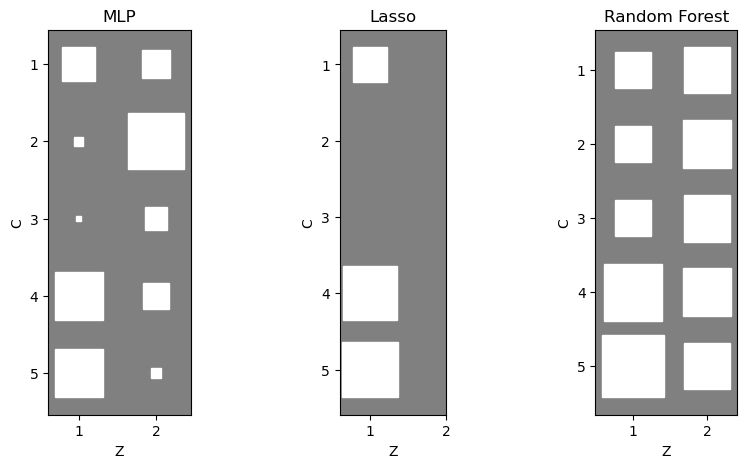

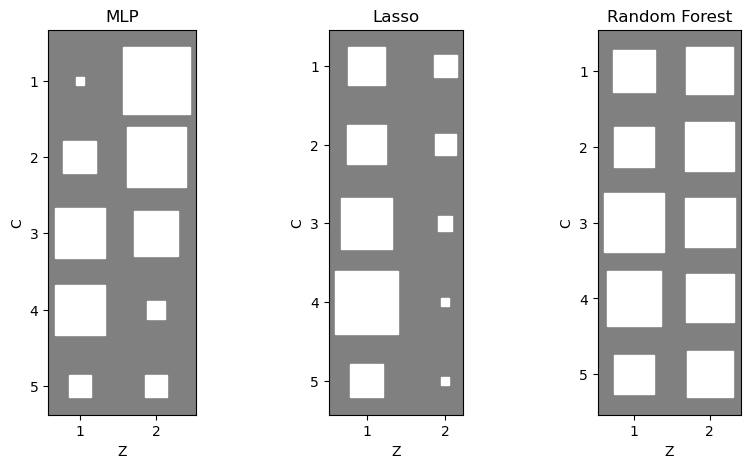

In [224]:
from disentangelement import *
codes_vae, Cs_vae, Ds_vae = get_important_latents(Rs_vae)
codes_vq, Cs_vq, Ds_vq = get_important_latents(Rs_vq)

In [256]:
from IPython.display import display, Latex
for i, C in enumerate(Ds_vq[0]):
    display(Latex(f'$C_{i+1}: {C:.3f}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [279]:
from IPython.display import display, Latex
E = np.array(loss).mean()
mlp="mlp"
display(Latex(f'$E= {E:.3f}$'))

<IPython.core.display.Latex object>

In [237]:
def plot_parameter_scatter(labels, prediction_lin, prediction_f):
    n_features = labels.shape[1]
    x_axis = np.arange(len(labels))
    
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ["mean", "Std", "Freaquency per Week", "Amplitude", "Phase"]

    fig, ax = plt.subplots(nrows=n_features, ncols=2,figsize=(20, 16))
    for i in range(n_features):    
        ax[0, i].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[0, i].scatter(x_axis, prediction_lin[:, i], c="r" , alpha = 0.2)
        ax[0, i].set_title(titles[i])
        ax[0, i].legend(handles=[blue_handle, red_handle], loc="upper right")
        
        ax[1, i].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[1, i].scatter(x_axis, prediction_f[:, i], c="r" , alpha = 0.2)
        ax[1, i].set_title(titles[i])
        ax[1, i].legend(handles=[blue_handle, red_handle], loc="upper right")
        set_y_lim(ax[i, 0], i)
        set_y_lim(ax[i, 1], i)
    fig.tight_layout()

In [166]:
latents = indices.view(z.shape[0], -1)
latents.shape

torch.Size([4000, 5])

In [215]:
codes_vae

array([[1., 1.],
       [1., 0.],
       [4., 4.]])

In [216]:
def plot_latents_vs_labels(latents, labels, codes):
    fig, axs = plt.subplots(codes.shape[1], codes.shape[0], figsize=(12, 10))
    titles = ["MLP", "Lasso", "Random Forest"]
    for i, code in enumerate(codes.T):
        for j in range(len(code)):
            lat1, lat2, lat3 = [int(c) for c in code]
            axs[i,j].scatter(latents[:,int(code[j])], labels[:,i])
            axs[i,j].set_xlabel("latent {}".format(code[j]))
            axs[i,j].set_ylabel("z {}".format(i))
            axs[i,j].set_title(titles[j])

#             axs[i,1].scatter(latents[:,lat2], lab'els[:,i])
#             axs[i,1].set_xlabel("latent {}".format(c2))
#             axs[i,1].set_ylabel("z {}".format(i))
#             axs[i,0].set_title(titles[i])

#             axs[i,2].scatter(latents[:,lat3], labels[:,i])
#             axs[i,2].set_xlabel("latent {}".format(c2))
#             axs[i,2].set_ylabel("z {}".format(i))
#             axs[i,0].set_title(titles[i])'
    
    

ValueError: not enough values to unpack (expected 3, got 2)

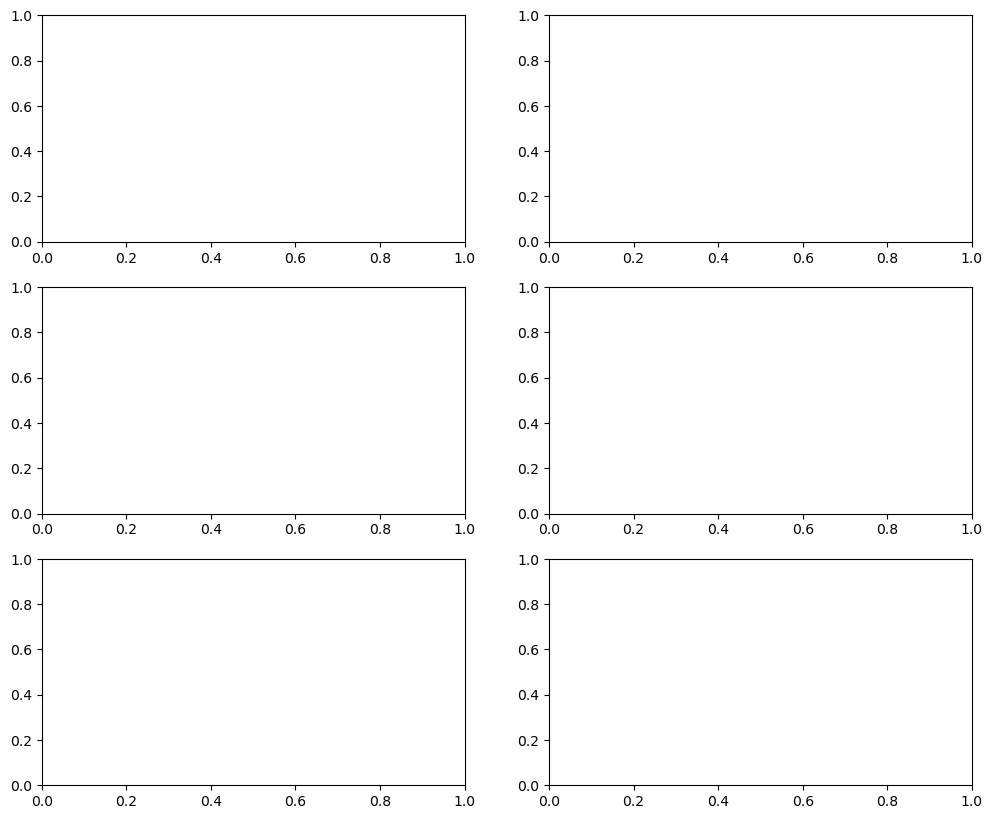

In [218]:
plot_latents_vs_labels(latents, y_train_vq, codes_vae)

/tmp/ipykernel_101/1324765137.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')


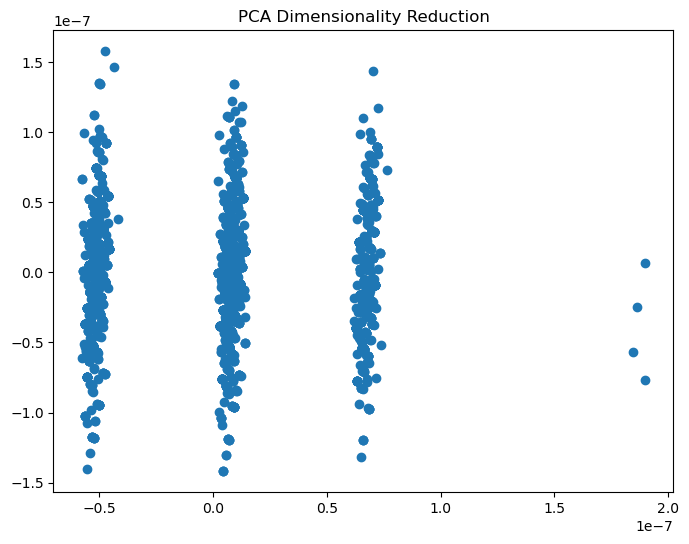

In [170]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(latents)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')
plt.title('PCA Dimensionality Reduction')
plt.show()

/tmp/ipykernel_101/2185305320.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap='viridis')


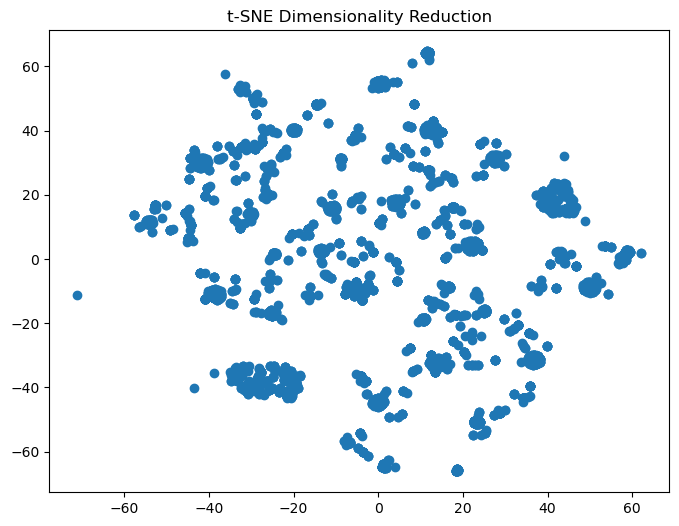

In [173]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(latents)

# Plot the reduced-dimensional data
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap='viridis')
plt.title('t-SNE Dimensionality Reduction')
plt.show()

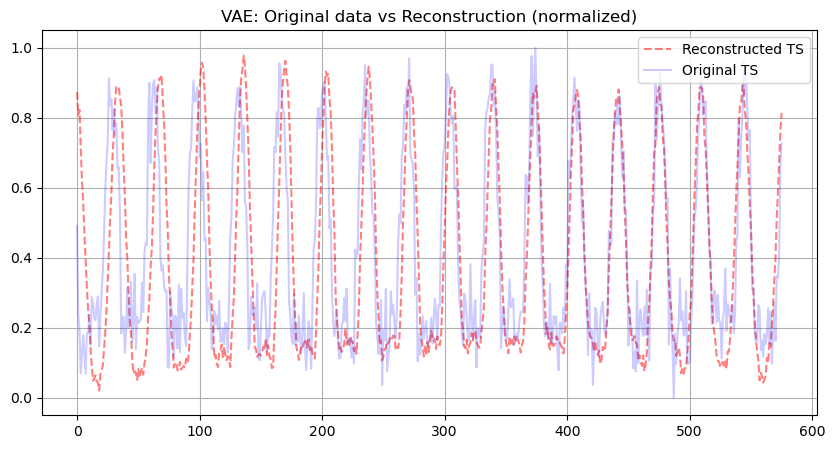

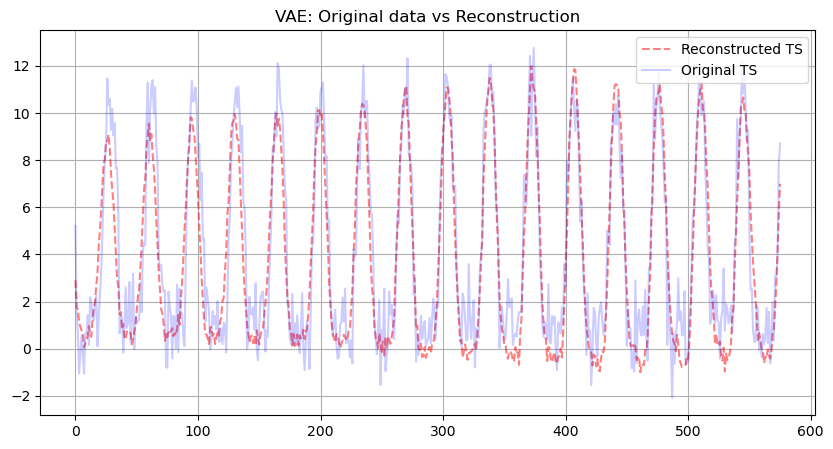

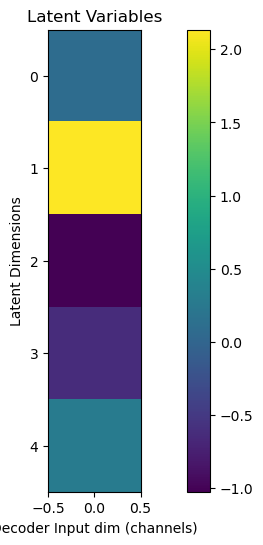

/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


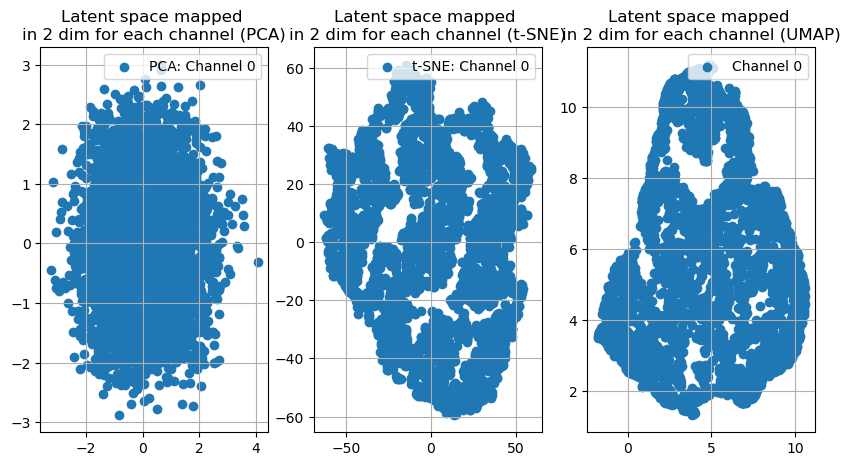

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [219]:
show_results(vae, train_data, args, plot_latent=True)